# Reduced matrix elements

In [1]:
from fast import *
from sympy import sqrt
from sympy.physics.wigner import wigner_6j
init_printing()

In [2]:
atoms = [["Rb", 85, 5], ["Rb", 87, 5], ["Cs", 133, 6]]
atom = atoms[2]

In [3]:
e1 = State(atom[0], atom[1], atom[2], 0, 1/Integer(2))
e2 = State(atom[0], atom[1], atom[2], 1, 3/Integer(2))
e3 = State(atom[0], atom[1], atom[2], 2, 5/Integer(2))
fine_states = [e1, e2, e3]
hyperfine_states = make_list_of_states(fine_states, "hyperfine", verbose=0)
Ne = len(hyperfine_states)

We calculate the fine reduced matrix elements using FAST

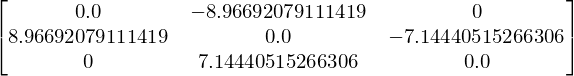

In [4]:
from scipy.constants import physical_constants
from math import pi
a0 = physical_constants["Bohr radius"][0]

# In meters.
r = Matrix(calculate_reduced_matrix_elements(fine_states))
r

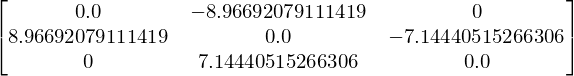

In [5]:
from scipy.constants import physical_constants
from math import pi
a0 = physical_constants["Bohr radius"][0]

# In meters.
r = Matrix(calculate_reduced_matrix_elements(fine_states))#*a0
r

In [6]:
mult=8.96692079111419/6.3405704948146
mult

The previous model using only fine states shows effective couplings

r1: 1.14989940728 Bohr radii

r2: 2.10757914438 Bohr radii

In [7]:
gamma32_mine = Transition(e3, e2).einsteinA
gamma32_mine/2/pi*1e-6

In [8]:
from scipy.constants import e, hbar, c, epsilon_0
from scipy.constants import physical_constants
from math import pi

a0 = physical_constants["Bohr radius"][0]
r32 = 6.13*a0
omega32 = Transition(e3,e2).omega
factor = (3*pi*hbar*c**3*epsilon_0)/e**2
gamma32_safronova = omega32**3 * r32**2 / (2*5.0/2.0+1)/factor
print gamma32_safronova/2/pi*1e-6

2.6149401689


In [9]:
Ji = 5.0/2
r32_ = sqrt((2.0*Ji+1)*factor*gamma32_safronova/omega32**3)
r32_/a0

In [10]:
gam = 2*pi*3.2e6
# If the branching ratios between
# 6D_5/2 -> 6P_3/2 and 6D_5/2 -> 7P_3/2
# are 0.74 and 0.26 as they are for
# 5D_5/2 -> 5P_3/2 and 5D_5/2 -> 6P_3/2 in rubidium, then
gam1 = gam*0.74
print gam1

14878582.8074


Now, let us asume that we have the reduced matrix elements $r_1 = \langle N, 1, 3/2|| T^1(\vec{r}) || N, 0, 1/2 \rangle$ and $r_2 = \langle N, 2, 5/2|| T^1(\vec{r}) || N, 1, 3/2 \rangle$. We can relate these numbers with the hyperfine reduced matrix elements via

\begin{equation}
    \langle N_i, L_i, J_i, F_i|| T^1(\vec{r}) || N_j, L_j, J_j, F_j \rangle = (-1)^{J_i+I+F_j+1} \sqrt{(2F_i+1)(2F_j+1)}\mathrm{Wigner6j}(J_i, F_i, I, F_j, J_j, 1)\langle N_i, L_i, J_i|| T^1(\vec{r}) || N_j, L_j, J_j \rangle
\end{equation}

In [11]:
r1, r2 = symbols("r1 r2", real=True)
N = atom[2]
def fine_reduced_matrix_element(Ni, Li, Ji, Nj, Lj, Jj):
    if (Ni, Li, Ji, Nj, Lj, Jj) == (N, 1, 3/Integer(2), N, 0, 1/Integer(2)):
        return r1
    if (Ni, Li, Ji, Nj, Lj, Jj) == (N, 0, 1/Integer(2), N, 1, 3/Integer(2)):
        return r1*(-1)**(Jj-Ji)
    
    if (Ni, Li, Ji, Nj, Lj, Jj) == (N, 2, 5/Integer(2), N, 1, 3/Integer(2)):
        return r2
    if (Ni, Li, Ji, Nj, Lj, Jj) == (N, 1, 3/Integer(2), N, 2, 5/Integer(2)):
        return r2*(-1)**(Jj-Ji)

    return 0
    

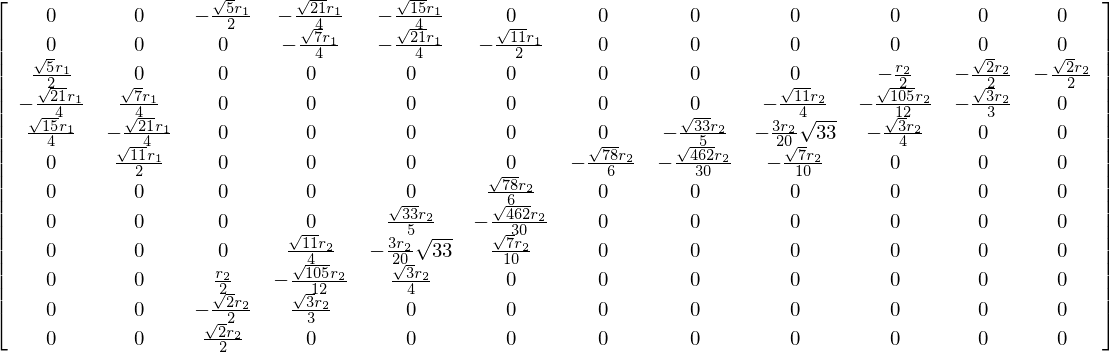

In [12]:
hyperfine_reduced = [[0 for j in range(Ne)] for i in range(Ne)]
II = hyperfine_states[0].i
for i, ei in enumerate(hyperfine_states):
    iso, Ni, Li, Ji, Fi = ei.quantum_numbers
    for j, ej in enumerate(hyperfine_states):
        iso, Nj, Lj, Jj, Fj = ej.quantum_numbers
        red = fine_reduced_matrix_element(Ni, Li, Ji, Nj, Lj, Jj)
        red *= (-1)**(Ji+II+Fj+1)*sqrt((2*Fi+1)*(2*Fj+1))
        #print Ji, Fi, II, Fj, Fj, 1
        # red *= wigner_6j(Ji, Fi, II, Fj, Fj, 1)
        red *= wigner_6j(Ji, Jj, 1, Fj, Fi, II)
        # red *= wigner_6j(Ji, Fi, II,
        #                  Fj, Fj, 1 )
        # ref *= wigner_6j(Ji, Jj, 1,
        #                  Jj, Fi, II)
        hyperfine_reduced[i][j] = red
        
hyperfine_reduced = Matrix(hyperfine_reduced)
hyperfine_reduced

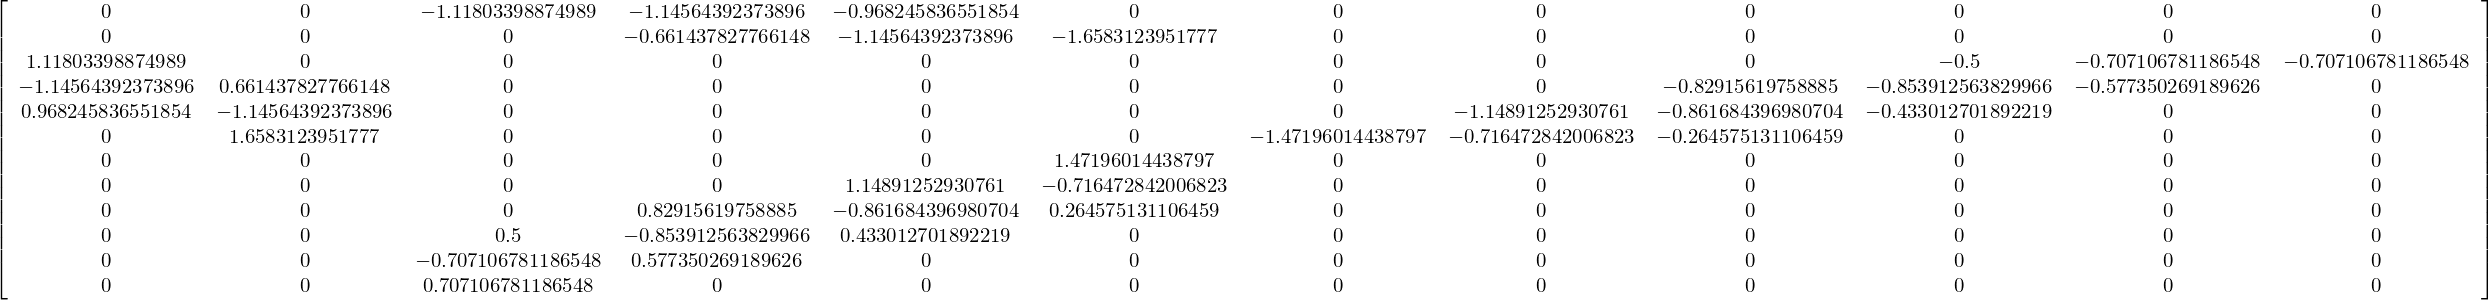

In [13]:
hyperfine_reduced.subs({r1: 1, r2: 1}).n()

We get the code to calculate the hyperfine reduced matrix elements.

In [14]:
for i in range(Ne):
    for j in range(i):
        if r1 in hyperfine_reduced[i, j].atoms():
            s = "r_1_"+str(i+1)+"_"+str(j+1)+" = "
            s += str(hyperfine_reduced[i, j].n())
            print s
        if r2 in hyperfine_reduced[i, j].atoms():
            s = "r_2_"+str(i+1)+"_"+str(j+1)+" = "
            s += str(hyperfine_reduced[i, j].n())
            print s
            

r_1_3_1 = 1.11803398874989*r1
r_1_4_1 = -1.14564392373896*r1
r_1_4_2 = 0.661437827766148*r1
r_1_5_1 = 0.968245836551854*r1
r_1_5_2 = -1.14564392373896*r1
r_1_6_2 = 1.6583123951777*r1
r_2_7_6 = 1.47196014438797*r2
r_2_8_5 = 1.14891252930761*r2
r_2_8_6 = -0.716472842006823*r2
r_2_9_4 = 0.82915619758885*r2
r_2_9_5 = -0.861684396980704*r2
r_2_9_6 = 0.264575131106459*r2
r_2_10_3 = 0.5*r2
r_2_10_4 = -0.853912563829966*r2
r_2_10_5 = 0.433012701892219*r2
r_2_11_3 = -0.707106781186548*r2
r_2_11_4 = 0.577350269189626*r2
r_2_12_3 = 0.707106781186548*r2


# Decay frequencies
Let us calculate explicitly what the hyperfine decay frequencies should be.

In [15]:
magnetic_states = make_list_of_states(fine_states, "magnetic")
hyperfine_states = make_list_of_states(fine_states, "hyperfine")
gamma = calculate_gamma_matrix(magnetic_states)

In [16]:
fin_bound, hyp_bound = calculate_boundaries(fine_states, magnetic_states)

In [17]:
hyp_bound

In [40]:
gamma21 = Transition(hyperfine_states[2], hyperfine_states[0]).einsteinA#/2/pi*1e-6
gamma32 = Transition(hyperfine_states[6], hyperfine_states[5]).einsteinA#/2/pi*1e-6
gamma32 = gamma32_safronova
print gamma21, gamma32

32886191.8978 16430153.6484


In [47]:
for i in range(2, 6):
    for j in range(0, 2):
        s = "gamma_"+str(i+1)+"_"+str(j+1)+" ="
        print s,
        for ii in range(hyp_bound[i][0], hyp_bound[i][1]):
            gammaij = sum([gamma[ii][jj] for jj in range(hyp_bound[j][0], hyp_bound[j][1])])/gamma21
        print str(gammaij)+"*gamma21"


gamma_3_1 = 1.0*gamma21
gamma_3_2 = 0.0*gamma21
gamma_4_1 = 0.75*gamma21
gamma_4_2 = 0.25*gamma21
gamma_5_1 = 0.416666666667*gamma21
gamma_5_2 = 0.583333333333*gamma21
gamma_6_1 = 0.0*gamma21
gamma_6_2 = 1.0*gamma21


In [48]:
for i in range(6, Ne):
    for j in range(2, 6):
        s = "gamma_"+str(i+1)+"_"+str(j+1)+" ="
        print s,
        for ii in range(hyp_bound[i][0], hyp_bound[i][1]):
            gammaij = sum([gamma[ii][jj] for jj in range(hyp_bound[j][0], hyp_bound[j][1])])/gamma32_mine
        print str(gammaij)+"*gamma32"

gamma_7_3 = 0.0*gamma32
gamma_7_4 = 0.0*gamma32
gamma_7_5 = 0.0*gamma32
gamma_7_6 = 1.0*gamma32
gamma_8_3 = 0.0*gamma32
gamma_8_4 = 0.0*gamma32
gamma_8_5 = 0.72*gamma32
gamma_8_6 = 0.28*gamma32
gamma_9_3 = 0.0*gamma32
gamma_9_4 = 0.458333333333*gamma32
gamma_9_5 = 0.495*gamma32
gamma_9_6 = 0.0466666666667*gamma32
gamma_10_3 = 0.214285714286*gamma32
gamma_10_4 = 0.625*gamma32
gamma_10_5 = 0.160714285714*gamma32
gamma_10_6 = 0.0*gamma32
gamma_11_3 = 0.6*gamma32
gamma_11_4 = 0.4*gamma32
gamma_11_5 = 0.0*gamma32
gamma_11_6 = 0.0*gamma32
gamma_12_3 = 1.0*gamma32
gamma_12_4 = 0.0*gamma32
gamma_12_5 = 0.0*gamma32
gamma_12_6 = 0.0*gamma32


In [21]:
gamma_3_1 =  32886191.8978
gamma_3_2 =  0.0
gamma_4_1 =  24664643.9233
gamma_4_2 =  8221547.97444
gamma_5_1 =  13702579.9574
gamma_5_2 =  19183611.9404
gamma_6_1 =  0.0
gamma_6_2 =  32886191.8978

gamma_7_3 =  0.0
gamma_7_4 =  0.0
gamma_7_5 =  0.0
gamma_7_6 =  16430153.6484
gamma_8_3 =  0.0
gamma_8_4 =  0.0
gamma_8_5 =  11829710.6268
gamma_8_6 =  4600443.02155
gamma_9_3 =  0.0
gamma_9_4 =  7530487.08884
gamma_9_5 =  8132926.05595
gamma_9_6 =  766740.503591
gamma_10_3 =  3520747.21037
gamma_10_4 =  10268846.0302
gamma_10_5 =  2640560.40778
gamma_10_6 =  0.0
gamma_11_3 =  9858092.18903
gamma_11_4 =  6572061.45935
gamma_11_5 =  0.0
gamma_11_6 =  0.0
gamma_12_3 =  16430153.6484
gamma_12_4 =  0.0
gamma_12_5 =  0.0
gamma_12_6 =  0.0

We prove that these amount to the total decay of the transitions as expected.

In [22]:
from math import pi
print (gamma_3_1+gamma_3_2)/2/pi*1e-6
print (gamma_4_1+gamma_4_2)/2/pi*1e-6
print (gamma_5_1+gamma_5_2)/2/pi*1e-6
print (gamma_6_1+gamma_6_2)/2/pi*1e-6

5.234
5.23399999999
5.234
5.234


In [23]:
print (gamma_7_3 +gamma_7_4 +gamma_7_5 +gamma_7_6)/2/pi*1e-6
print (gamma_8_3 +gamma_8_4 +gamma_8_5 +gamma_8_6)/2/pi*1e-6
print (gamma_9_3 +gamma_9_4 +gamma_9_5 +gamma_9_6)/2/pi*1e-6
print (gamma_10_3+gamma_10_4+gamma_10_5+gamma_10_6)/2/pi*1e-6
print (gamma_11_3+gamma_11_4+gamma_11_5+gamma_11_6)/2/pi*1e-6
print (gamma_12_3+gamma_12_4+gamma_12_5+gamma_12_6)/2/pi*1e-6

2.6149401689
2.61494016889
2.6149401689
2.61494016889
2.6149401689
2.6149401689


We get the hyperfine frequencies for all atoms.

In [53]:
for atom in atoms:
    e1 = State(atom[0], atom[1], atom[2], 0, 1/Integer(2))
    e2 = State(atom[0], atom[1], atom[2], 1, 3/Integer(2))
    e3 = State(atom[0], atom[1], atom[2], 2, 5/Integer(2))
    fine_states = [e1, e2, e3]
    hyperfine_states = make_list_of_states(fine_states, "hyperfine", verbose=0)
    Ne = len(hyperfine_states)
    print
    for i in range(Ne):
        print "omega_"+str(i+1)+" =",hyperfine_states[i].omega-hyperfine_states[0].omega


omega_1 = 0.0
omega_2 = 19074074839.2
omega_3 = 2.41420092267e+15
omega_4 = 2.41420110658e+15
omega_5 = 2.414201505e+15
omega_6 = 2.41420226503e+15
omega_7 = 4.84165447401e+15
omega_8 = 4.84165453274e+15
omega_9 = 4.84165458882e+15
omega_10 = 4.84165463619e+15
omega_11 = 4.84165467029e+15
omega_12 = 4.8416546881e+15

omega_1 = 0.0
omega_2 = 42943577360.1
omega_3 = 2.41421544943e+15
omega_4 = 2.41421590321e+15
omega_5 = 2.41421688929e+15
omega_6 = 2.41421856472e+15
omega_7 = 4.84167009525e+15
omega_8 = 4.84167027636e+15
omega_9 = 4.84167042059e+15
omega_10 = 4.84167052073e+15

omega_1 = 0.0
omega_2 = 57759008871.6
omega_3 = 2.20998822144e+15
omega_4 = 2.20998917161e+15
omega_5 = 2.20999043634e+15
omega_6 = 2.20999201399e+15
omega_7 = 4.26305337164e+15
omega_8 = 4.26305354441e+15
omega_9 = 4.26305369061e+15
omega_10 = 4.26305380902e+15
omega_11 = 4.26305389868e+15
omega_12 = 4.26305395885e+15


omega_1 = 0.0
omega_2 = 57759008871.6
omega_3 = 2.20998822144e+15
omega_4 = 2.20998917161e+15
omega_5 = 2.20999043634e+15
omega_6 = 2.20999201399e+15
omega_7 = 4.26305337164e+15
omega_8 = 4.26305354441e+15
omega_9 = 4.26305369061e+15
omega_10 = 4.26305380902e+15
omega_11 = 4.26305389868e+15
omega_12 = 4.26305395885e+15


In [25]:
r_1_3_1 = 1.11803398874989*r1
r_1_4_1 = -1.14564392373896*r1
r_1_4_2 = 0.661437827766148*r1
r_1_5_1 = 0.968245836551854*r1
r_1_5_2 = -1.14564392373896*r1
r_1_6_2 = 1.6583123951777*r1

r_2_7_6 = 1.47196014438797*r2
r_2_8_5 = 1.14891252930761*r2
r_2_8_6 = -0.716472842006823*r2
r_2_9_4 = 0.82915619758885*r2
r_2_9_5 = -0.861684396980704*r2
r_2_9_6 = 0.264575131106459*r2
r_2_10_3 = 0.5*r2
r_2_10_4 = -0.853912563829966*r2
r_2_10_5 = 0.433012701892219*r2
r_2_11_3 = -0.707106781186548*r2
r_2_11_4 = 0.577350269189626*r2
r_2_12_3 = 0.707106781186548*r2

gamma_3_1 =  32886191.8978
gamma_4_1 =  24664643.9233
gamma_4_2 =  8221547.97444
gamma_5_1 =  13702579.9574
gamma_5_2 =  19183611.9404
gamma_6_2 =  32886191.8978

gamma_7_6 =  14878582.8074
gamma_8_5 =  10712579.6213
gamma_8_6 =  4166003.18607
gamma_9_4 =  6819350.45339
gamma_9_5 =  7364898.48966
gamma_9_6 =  694333.864345
gamma_10_3 =  3188267.74444
gamma_10_4 =  9299114.25463
gamma_10_5 =  2391200.80833
gamma_11_3 =  8927149.68444
gamma_11_4 =  5951433.12296
gamma_12_3 =  14878582.8074

In [26]:
from sympy import symbols, diff, Sum, oo
N, n = symbols("N n", real=True)
Pn = N**n/(1+N)**(1+n)
Pn

In [27]:
solve(diff(Pn.subs({n:1}), N), N)

In [28]:
Pn.subs({n:1, N:1})

In [29]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [30]:
def Pn(n, N): return N**n/(1.0+N)**(1.0+n)

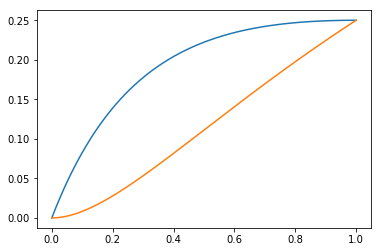

In [31]:
N = np.linspace(0, 1, 500)
P0 = Pn(0, N)
P1 = Pn(1, N)
Pm = 1-P0-P1
#plt.plot(N, P0)
plt.plot(N, P1)
plt.plot(N, Pm)

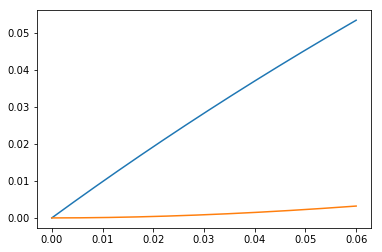

In [32]:
N = np.linspace(0, 0.06, 500)
P0 = Pn(0, N)
P1 = Pn(1, N)
Pm = 1-P0-P1
#plt.plot(N, P0)
plt.plot(N, P1)
plt.plot(N, Pm)

In [33]:
Nsmall = 0.01
1-Pn(0, Nsmall)-Pn(1, Nsmall), Pn(1, Nsmall), (1-Pn(0, Nsmall)-Pn(1, Nsmall))/Pn(1, Nsmall)

In [34]:
Nmedium = 0.056
1-Pn(0, Nmedium)-Pn(1, Nmedium), Pn(1, Nmedium), (1-Pn(0, Nmedium)-Pn(1, Nmedium))/ Pn(1, Nmedium)

In [35]:
sum([Pn(i, 0.25) for i in range(0, 10)])